# Static comparison vs init (latest vs epoch_0)

- Columns: Block 1 (left), Block 2 (right)
- Rows (5):
  1) Discretized A eigenvalues overlaid with the unit circle (init in black)
  2) Singular values of B̄ (x: model configs incl. init, y: SVs; violins)
  3) Singular values of C̄ (same layout)
  4) Singular values of GLU W1 (same layout)
  5) Singular values of GLU W2 (same layout)

Configs use alias "latest"; init is baseline ("1-5S window (baseline)") at alias "epoch_0" and is plotted in black.

In [1]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
from typing import Any, BinaryIO

def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    Lambda_bar = jnp.concat([Lambda_bar, jnp.conj(Lambda_bar)])
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta

%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from typing import List, Dict, Any
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Reuse: get_discretized_ssm_parameters, FOUR_CONFIGS, load_model_and_state_from_checkpoint_wandb
@dataclass
class ModelConfig:
    label: str
    artifact_prefix: str  # e.g., 'melinajingting-ucl/foundational_ssm_pretrain/<artifact_name>'
    model_cls: Any        # SSMFoundationalDecoder or SSMDownstreamDecoder

@dataclass
class StaticConfig:
    label: str
    artifact_prefix: str
    model_cls: Any
    
# Helper to test presence of data for a matrix key

def any_data_for_key(init_specs, latest_specs_by_label, key: str, blocks_to_plot, config_labels) -> bool:
    for blk in blocks_to_plot:
        if init_specs[blk][key].size:
            return True
        for label in config_labels:
            if latest_specs_by_label[label][blk][key].size:
                return True
    return False

# Violin helper that keeps empty slots and removes per-row titles

def violin_for_matrix(init_specs, latest_specs_by_label, blocks_to_plot, config_labels, ax_grid, color_map, row_idx: int, key: str, ylabel: str):
    cat_order = ['Init'] + config_labels
    for c, blk in enumerate(blocks_to_plot):
        ax = ax_grid[row_idx, c]
        positions = np.arange(1, len(cat_order) + 1)
        xlim = (0.5, len(cat_order) + 0.5)
        for i, lab in enumerate(cat_order):
            if lab == 'Init':
                vals = np.asarray(init_specs[blk][key]).ravel()
                color = 'black'; edge = 'black'; alpha = 0.6
            else:
                vals = np.asarray(latest_specs_by_label.get(lab, [{}])[blk].get(key, np.array([]))).ravel() if lab in latest_specs_by_label else np.array([])
                color = color_map.get(lab, 'gray'); edge = 'white'; alpha = 0.85
            if vals.size:
                parts = ax.violinplot([np.abs(vals)], positions=[positions[i]], showmeans=False, showextrema=False, showmedians=False)
                body = parts['bodies'][0]
                body.set_facecolor(color)
                body.set_edgecolor(edge)
                body.set_alpha(alpha)
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xlabel("")
        if c == 0:
            ax.set_ylabel(ylabel)
        ax.grid(alpha=0.3)
        
def load_model_by_alias(prefix: str, alias: str, model_cls: Any):
    artifact_full = f"{prefix}:{alias}"
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full, model_cls=model_cls)
    return model


def collect_block_spectra(model) -> List[Dict[str, np.ndarray]]:
    """For each block, return dict of arrays: A_eigs (complex), B_bar_svs, C_bar_svs, GLU_W1_svs, GLU_W2_svs."""
    blocks = []
    for block in model.ssm_blocks:
        Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(block.ssm)
        entry: Dict[str, np.ndarray] = {}
        # A eigenvalues (complex)
        entry["A_eigs"] = np.asarray(np.array(Lambda_bar))
        # Singular values
        try:
            entry["B_bar_svs"] = np.asarray(jnp.linalg.svd(B_bar, compute_uv=False))
        except Exception:
            entry["B_bar_svs"] = np.array([])
        try:
            entry["C_bar_svs"] = np.asarray(jnp.linalg.svd(C_tilde, compute_uv=False))
        except Exception:
            entry["C_bar_svs"] = np.array([])
        # GLU weights
        if hasattr(block, "glu") and hasattr(block.glu, "w1") and hasattr(block.glu, "w2"):
            try:
                entry["GLU_W1_svs"] = np.asarray(jnp.linalg.svd(jnp.asarray(block.glu.w1.weight), compute_uv=False))
            except Exception:
                entry["GLU_W1_svs"] = np.array([])
            try:
                entry["GLU_W2_svs"] = np.asarray(jnp.linalg.svd(jnp.asarray(block.glu.w2.weight), compute_uv=False))
            except Exception:
                entry["GLU_W2_svs"] = np.array([])
        else:
            entry["GLU_W1_svs"] = np.array([])
            entry["GLU_W2_svs"] = np.array([])
        blocks.append(entry)
    return blocks

In [3]:
# Use the same configs already defined in the notebook (FOUR_CONFIGS)
# Baseline init (epoch_0) comes from the first config (1-5S window (baseline))
MODEL_CONFIGS = [
    StaticConfig("Baseline", "melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_checkpoint", SSMFoundationalDecoder),
    StaticConfig("Fixed 1S window", "melinajingting-ucl/foundational_ssm_pretrain/l2_with_context_reaching_1Swindow_checkpoint", SSMFoundationalDecoder),
    StaticConfig("With context", "melinajingting-ucl/foundational_ssm_pretrain/l2_with_context_reaching_checkpoint", SSMFoundationalDecoder),
    StaticConfig("No GLU", "melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_checkpoint", SSMFoundationalDecoder),
    StaticConfig("Freeze A", "melinajingting-ucl/foundational_ssm_pretrain/l2_freeze_a_reaching_checkpoint", SSMFoundationalDecoder),
    # StaticConfig("4 Layers", "melinajingting-ucl/foundational_ssm_pretrain/l4_reaching_checkpoint", SSMFoundationalDecoder),
]

BASELINE_LABEL = MODEL_CONFIGS[0].label
BASELINE_PREFIX = MODEL_CONFIGS[0].artifact_prefix
BASELINE_MODELCLS = MODEL_CONFIGS[0].model_cls

ALL_CONFIGS: List[StaticConfig] = [
    StaticConfig(cfg.label, cfg.artifact_prefix, cfg.model_cls) for cfg in MODEL_CONFIGS
]

# Load init (epoch_0) from the baseline and latest for each config
init_model = load_model_by_alias(BASELINE_PREFIX, "epoch_0", BASELINE_MODELCLS)
init_specs = collect_block_spectra(init_model)

latest_specs_by_label: Dict[str, List[Dict[str, np.ndarray]]] = {}
for cfg in MODEL_CONFIGS:
    try:
        m_latest = load_model_by_alias(cfg.artifact_prefix, "latest", cfg.model_cls)
        latest_specs_by_label[cfg.label] = collect_block_spectra(m_latest)
    except Exception as e:
        print(f"Skip {cfg.label} (latest): {e}")

# Determine which blocks to plot based on init model
num_blocks = len(init_specs)
blocks_to_plot = list(range(min(2, num_blocks)))

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


Skip No GLU (latest): Could not find checkpoint artifact: melinajingting-ucl/foundational_ssm_pretrain/l2_no_glu_checkpoint:latest


wandb:   3 of 3 files downloaded.  


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


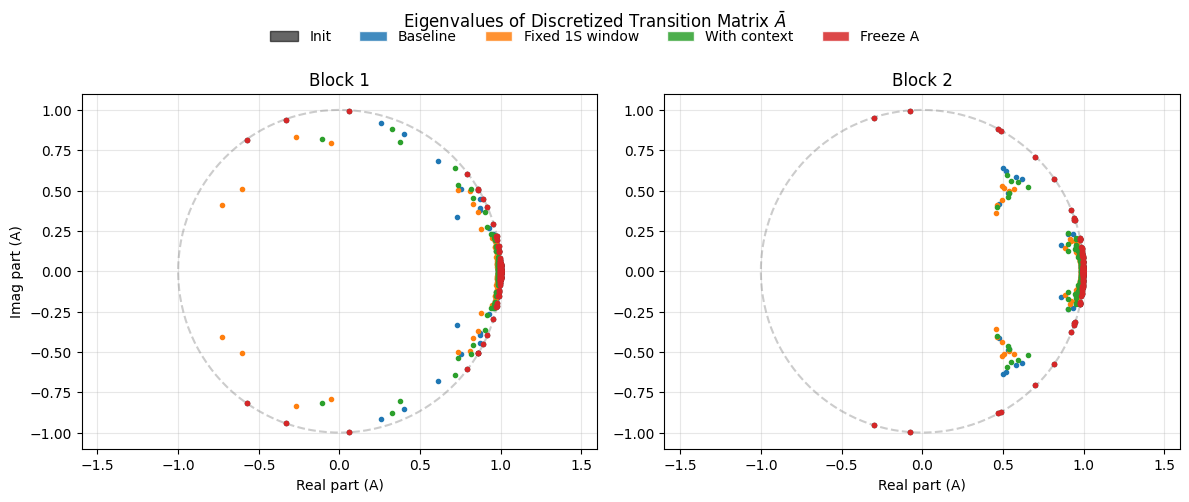

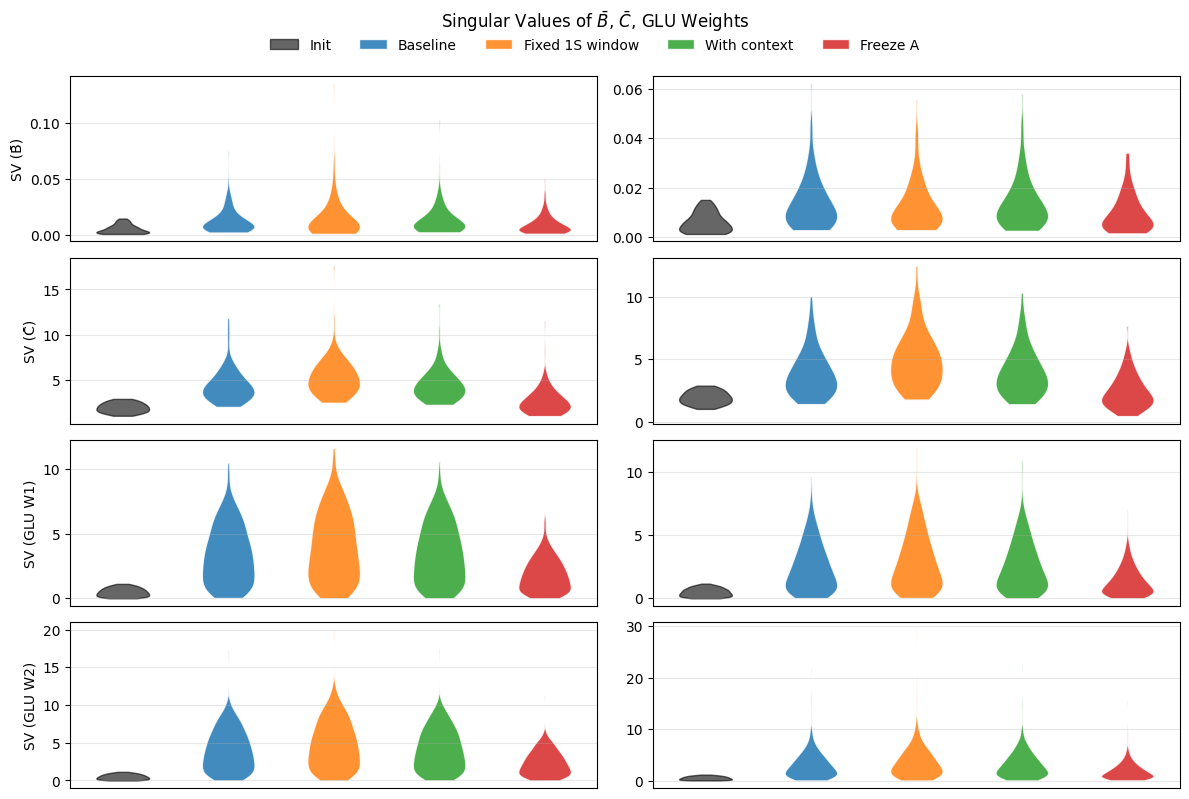

In [4]:
# Legend color mapping
colors = plt.cm.tab10.colors
config_labels = list(latest_specs_by_label.keys())  # only those that successfully loaded
COLOR_MAP: Dict[str, Any] = {label: colors[i % len(colors)] for i, label in enumerate(config_labels)}

# ---------- Figure 1: A eigenvalues (1 row x 2 cols) ----------
figA, axesA = plt.subplots(1, max(1, len(blocks_to_plot)), figsize=(12, 5))
axesA = np.atleast_1d(axesA)

theta = np.linspace(0, 2 * np.pi, 256)
for c, blk in enumerate(blocks_to_plot):
    ax = axesA[c]
    # unit circle
    ax.plot(np.cos(theta), np.sin(theta), linestyle='--', color='gray', alpha=0.4)
    # init in black
    A_init = init_specs[blk]["A_eigs"]
    ax.plot(A_init.real, A_init.imag, 'o', color='black', markersize=3)
    # latest per config (colored)
    for label in config_labels:
        A_eigs = latest_specs_by_label[label][blk]["A_eigs"]
        ax.plot(A_eigs.real, A_eigs.imag, 'o', color=COLOR_MAP[label], markersize=3)
    ax.set_title(f"Block {c+1}")
    ax.set_xlabel("Real part (A)")
    if c == 0:
        ax.set_ylabel("Imag part (A)")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(alpha=0.3)

# Legend for A-figure (tight spacing)
legend_handles_A: List[Patch] = [Patch(facecolor='black', edgecolor='black', alpha=0.6, label='Init')]
legend_handles_A += [Patch(facecolor=COLOR_MAP[lbl], edgecolor='white', alpha=0.85, label=lbl) for lbl in config_labels]
figA.legend(handles=legend_handles_A, labels=[h.get_label() for h in legend_handles_A],
           loc='upper center', ncol=min(len(legend_handles_A), 6), bbox_to_anchor=(0.5, 0.98), frameon=False)
figA.suptitle(r"Eigenvalues of Discretized Transition Matrix $\bar{A}$", y=0.995)
# Reduce space between legend and axes
figA.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# ---------- Figure 2: Singular values (4 rows x 2 cols) ----------
figV, axesV = plt.subplots(4, max(1, len(blocks_to_plot)), figsize=(12, 8))
axesV = np.atleast_2d(axesV)

# Draw rows: B, C, GLU W1, GLU W2
violin_for_matrix(init_specs, latest_specs_by_label, blocks_to_plot, config_labels, axesV, COLOR_MAP, 0, "B_bar_svs", "SV (B\u0304)")
violin_for_matrix(init_specs, latest_specs_by_label, blocks_to_plot, config_labels, axesV, COLOR_MAP, 1, "C_bar_svs", "SV (C\u0304)")
if any_data_for_key(init_specs, latest_specs_by_label, "GLU_W1_svs", blocks_to_plot, config_labels):
    violin_for_matrix(init_specs, latest_specs_by_label, blocks_to_plot, config_labels, axesV, COLOR_MAP, 2, "GLU_W1_svs", "SV (GLU W1)")
else:
    for c in range(len(blocks_to_plot)):
        ax = axesV[2, c]
        cat_order = ['Init'] + config_labels
        ax.set_xlim(0.5, len(cat_order) + 0.5)
        ax.set_xticks([])
        if c == 0:
            ax.set_ylabel("SV (GLU W1)")
        ax.grid(alpha=0.3)
if any_data_for_key(init_specs, latest_specs_by_label, "GLU_W2_svs", blocks_to_plot, config_labels):
    violin_for_matrix(init_specs, latest_specs_by_label, blocks_to_plot, config_labels, axesV, COLOR_MAP, 3, "GLU_W2_svs", "SV (GLU W2)")
else:
    for c in range(len(blocks_to_plot)):
        ax = axesV[3, c]
        cat_order = ['Init'] + config_labels
        ax.set_xlim(0.5, len(cat_order) + 0.5)
        ax.set_xticks([])
        if c == 0:
            ax.set_ylabel("SV (GLU W2)")
        ax.grid(alpha=0.3)

# Legend for violins (tight above plots)
legend_handles_V: List[Patch] = [Patch(facecolor='black', edgecolor='black', alpha=0.6, label='Init')]
legend_handles_V += [Patch(facecolor=COLOR_MAP[lbl], edgecolor='white', alpha=0.85, label=lbl) for lbl in config_labels]
figV.legend(handles=legend_handles_V, labels=[h.get_label() for h in legend_handles_V],
            loc='upper center', ncol=min(len(legend_handles_V), 6), bbox_to_anchor=(0.5, 0.975), frameon=False)

# Group title for the violins
figV.suptitle(r"Singular Values of $\bar{B}$, $\bar{C}$, GLU Weights", y=0.995)
# Reduce space between legend and the first violin row; tighten vertical spacing between rows
figV.tight_layout(rect=[0, 0, 1, 0.98])
figV.subplots_adjust(hspace=0.1)
plt.show()